Feature selection

In [6]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [7]:
df = pd.read_csv(r'D:/PYTHON/heart_disease.csv', sep=";")
print(df.head())


    age  sex   cp  trestbps    cho  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  target  
0    3.0  0.0   6.0    0       1  
1    2.0  3.0   3.0    2       1  
2    2.0  2.0   7.0    1       1  
3    3.0  0.0   3.0    0       1  
4    1.0  0.0   3.0    0       1  


In [8]:
#check for NaNs...
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
cho         0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64

Correlation Plot

<Axes: >

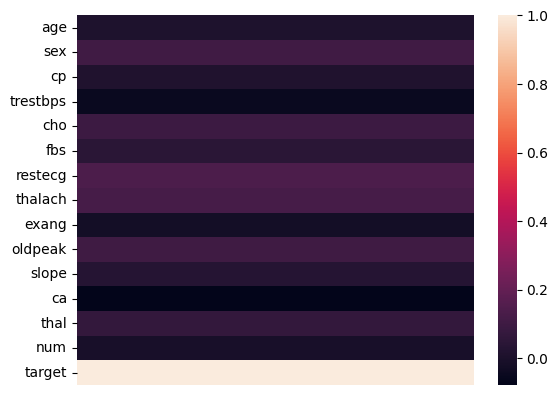

In [9]:
corr= df.corr().iloc[-1,:].to_numpy().reshape(15,1)
sns.heatmap(corr, yticklabels=df.columns, xticklabels= 0)

Feature Selection - L1 Regularization

In [10]:
#declare the feature values and labels then split data into training/validation sets


feats= df.iloc[:,:-1]
labels= df.iloc[:,-1]

x_train, x_devel, y_train, y_devel= train_test_split(feats, labels, test_size= 0.1, random_state= 20)

#train linear model with L1 penalty
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc= LinearSVC(C= 1.0, penalty= 'l1', dual= False).fit(x_train, y_train)
svc_mod= SelectFromModel(lsvc, prefit= True)

#get non-zeroed features 
x_train_svc= svc_mod.transform(x_train) #training set w/non-zeroed features
selected_feats_svc= pd.DataFrame(svc_mod.inverse_transform(x_train_svc), index= x_train.index, columns= x_train.columns)
selected_cols_svc= selected_feats_svc.columns[selected_feats_svc.var() != 0]

#get development set that has only the non-zeroed features
x_devel_svc= x_devel[selected_cols_svc]

#see which features were retained
print('Features retained: ', selected_cols_svc)

Features retained:  Index(['age', 'sex', 'trestbps', 'cho', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


Feature Selection - SelectKBest

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
kbest_feats= SelectKBest(f_classif, k=5)

#get top 5 best features
x_train_kbest= kbest_feats.fit_transform(x_train, y_train)
selected_feats_kbest= pd.DataFrame(kbest_feats.inverse_transform(x_train_kbest), index= x_train.index, columns= x_train.columns)
selected_cols_kbest= selected_feats_kbest.columns[selected_feats_kbest.var() != 0]

#get development set that has the top 5 features
x_devel_kbest= x_devel[selected_cols_kbest]

#see which features were retained
print('Features retained: ', selected_cols_kbest)

Features retained:  Index(['sex', 'cho', 'restecg', 'thalach', 'oldpeak'], dtype='object')


Feature Selection - Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

#create and train a random forest
forest= RandomForestClassifier(n_estimators= 1000, random_state= 20)
forest.fit(x_train, y_train)

#get the most important features
forest_feats= SelectFromModel(forest, threshold= 'median')
forest_feats.fit(x_train, y_train)

#get training and development sets that have only the most important features
x_train_forest= forest_feats.transform(x_train)
x_devel_forest= forest_feats.transform(x_devel)

#see which features were retained
for i in forest_feats.get_support(indices= True):
    print(x_train.columns[i])

age
cp
trestbps
cho
thalach
oldpeak
ca


SVM to Decide Feature Set

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score

def eval_svm(train_feats, test_feats, train_labs, test_labs):
    """
    INPUT: train_feats and test_feats are either 2D numpy arrays or pd dataframes with the feature values for the train/test sets 
    train_labs, test_labs are either 1D numpy arrays or pd series with the corresponding labels to the train/test features
    
    OUTPUT: classification_results is a string of results, incl. precision, recall, and f1-score for each class
    """
    #scale features before using in SVM
    scaler= StandardScaler()
    train_feats_scale= scaler.fit_transform(train_feats)
    test_feats_scale= scaler.transform(test_feats)
    
    svm= SVC()
    svm.fit(train_feats_scale, train_labs)
    predicts= svm.predict(test_feats_scale)
    
    precision= precision_score(test_labs, predicts, average= None, zero_division= 0)
    recall= recall_score(test_labs, predicts, average= None, zero_division= 0)
    
    return precision, recall

#get performance of model that uses all features
prec_allfeats, rec_allfeats= eval_svm(x_train, x_devel, y_train, y_devel)
#get performance of model that uses features from L1 regularization
prec_svc, rec_svc= eval_svm(x_train_svc, x_devel_svc, y_train, y_devel)

#get performance of model that uses features from SelectKBest
prec_kbest, rec_kbest= eval_svm(x_train_kbest, x_devel_kbest, y_train, y_devel)

#get performance of model that uses features from random forest
prec_forest, rec_forest= eval_svm(x_train_forest, x_devel_forest, y_train, y_devel)

print('SVM precision and recall, all features: ', prec_allfeats, rec_allfeats, '\n'+'SVM precision and recall, L1 regularization features: ', prec_svc, rec_svc)
print('SVM precision and recall, top 5 features: ', prec_kbest, rec_kbest, '\n'+'SVM precision and recall, random forest features: ', prec_forest, rec_forest, '\n')   
print('Average recalls: ', np.mean(rec_allfeats), np.mean(rec_svc), np.mean(rec_kbest), np.mean(rec_forest))

SVM precision and recall, all features:  [0.5        0.66666667] [0.41666667 0.73684211] 
SVM precision and recall, L1 regularization features:  [0.5        0.66666667] [0.41666667 0.73684211]
SVM precision and recall, top 5 features:  [0.44444444 0.63636364] [0.33333333 0.73684211] 
SVM precision and recall, random forest features:  [0.71428571 0.70833333] [0.41666667 0.89473684] 

Average recalls:  0.5767543859649122 0.5767543859649122 0.5350877192982456 0.6557017543859649
